In [1]:
import os 

import pandas as pd
import matplotlib.pyplot as plt

import simtk.unit as unit
from simtk.openmm.app import *
from simtk.openmm import *

from MDAnalysis.coordinates.DCD import DCDFile

In [2]:
with open("system.xml", "r") as f:
    system = XmlSerializer.deserialize(f.read())
coords = PDBFile("equilibrated.pdb")

for force in system.getForces():
    if isinstance(force, HarmonicBondForce):
        force.setForceGroup(1)
    elif isinstance(force, HarmonicAngleForce):
        force.setForceGroup(2)
    elif isinstance(force, PeriodicTorsionForce):
        force.setForceGroup(3)
    elif isinstance(force, NonbondedForce):
        force.setForceGroup(4)

In [3]:
dt   = 2.0 * unit.femtoseconds
Temp = 298.15 * unit.kelvin
Pres = 1.01325 * unit.bar
integrator = LangevinIntegrator(Temp, 1.0 / unit.picoseconds, dt)
barostat   = MonteCarloBarostat(Pres, Temp, 100)
system.addForce(barostat)

simulation = Simulation(
    coords.topology, 
    system, 
    integrator,
    Platform.getPlatformByName('CPU')
)

In [4]:
potential_energy = []

with DCDFile("equilibration.dcd") as dcd:
    header = dcd.header

    for xyz, box in zip(dcd.readframes()[0], dcd.readframes()[1]):
        box_vectors = unit.Quantity(
            value=[Vec3(box[0],0,0), Vec3(0,box[2],0), Vec3(0,0,box[5])], 
            unit=unit.angstrom,
        )
        
        simulation.context.setPositions(xyz * unit.angstrom)
        simulation.context.setPeriodicBoxVectors(*box_vectors)
        
        bond_energy = simulation.context.getState(getEnergy=True, groups={1})
        bond_energy = bond_energy.getPotentialEnergy() / unit.kilocalorie_per_mole

        angle_energy = simulation.context.getState(getEnergy=True, groups={2})
        angle_energy = angle_energy.getPotentialEnergy() / unit.kilocalorie_per_mole

        torsion_energy = simulation.context.getState(getEnergy=True, groups={3})
        torsion_energy = torsion_energy.getPotentialEnergy() / unit.kilocalorie_per_mole

        nonbonded_energy = simulation.context.getState(getEnergy=True, groups={4})
        nonbonded_energy = nonbonded_energy.getPotentialEnergy() / unit.kilocalorie_per_mole

        total_energy = (bond_energy + angle_energy + torsion_energy + nonbonded_energy)
        
        potential_energy.append([
            bond_energy,
            angle_energy,
            torsion_energy,
            nonbonded_energy,
            total_energy
        ])

In [6]:
f = open("potential_energy.csv", "w")
f.writelines(f'"frame","Bond","Angle","Torsion","Nonbonded","Total"\n')
i = 0
for energy in potential_energy:
    f.writelines(f"{i},{energy[0]:.5f},{energy[1]:.5f},{energy[2]:.5f},{energy[3]:.5f},{energy[4]:.5f}\n")
    i += 1
f.close()

In [7]:
data = pd.read_csv("potential_energy.csv")
data.head()

,frame,Bond,Angle,Torsion,Nonbonded,Total
0,0,0.73772,1.42767,1.68558,-10258.52229,-10254.67133
1,1,0.43406,2.07575,1.31041,-9707.86710,-9704.04688
2,2,0.01419,2.97840,1.31419,-9373.23679,-9368.93001
3,3,0.04432,2.24195,0.88152,-9247.11448,-9243.94669
4,4,0.02352,3.37400,1.95705,-9161.83204,-9156.47746


<AxesSubplot:>

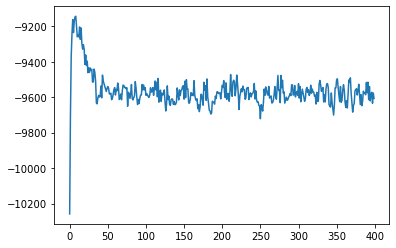

In [9]:
data["Nonbonded"].plot()